# Large-time asymptotics for the SABR mass at zero
***

Reference: 
A. Gulisashvili, B. Horvath, A. Jacquier.
Mass at zero in the uncorrelated SABR model. 
Quantitative Finance, 18(10): 1753-1765, 2018.
https://www.tandfonline.com/doi/full/10.1080/14697688.2018.1432883

In [1]:
import numpy as np
from scipy.integrate import quad
from scipy.special import gamma, gammainc, hyp1f1
import matplotlib.pylab as plt
from decimal import Decimal
from math import factorial
import time
import pandas as pd

\begin{align*}
\mathbb{P}(X_\infty=0):=\lim_{t\uparrow\infty}\mathbb{P}(X_t = 0) 
& = 
\frac{y_0}{\nu\sqrt{2 \pi}}\int_{0}^{\infty}\left[1-\Gamma\left(\frac{1}{2(1-\beta)},\frac{x_0^{2(1-\beta)}}{2r(1-\beta)^2}\right)\right]
r^{-3/2}\exp\left(-\frac{y_0^2}{2 \nu^2 r}\right)\mathrm{d}r\\
& = 
1 - 
\frac{y_0}{\nu\sqrt{2 \pi}}\int_{0}^{\infty}\Gamma\left(\frac{1}{2(1-\beta)},\frac{x_0^{2(1-\beta)}}{2r(1-\beta)^2}\right)
r^{-3/2}\exp\left(-\frac{y_0^2}{2 \nu^2 r}\right)\mathrm{d}r.
\end{align*}

In [2]:
def integrand(r, beta, x0, y0,nu):
    b1 = 1.-beta
    return gammainc(0.5/b1, x0**(2.*b1)/(2.*r*b1*b1)) * r**(-1.5)*np.exp(-(y0*y0)/(2.*nu*nu*r))

In [3]:
def SABR_mass_0_infty(y0, nu, beta, x0, RMax = 60):
    return 1. - (y0/(nu*np.sqrt(2.*np.pi)))*quad(lambda r: integrand(r, beta, x0, y0,nu),0.,RMax, epsrel=1.49e-10, limit=100)[0]

In [13]:
rho, nu, beta, x0, y0, T = 0., 3., 0.9, 0.05, 0.1, 10.2
nu, beta, rho, x0, y0, T = 0.3, 0., 0., 0.35, 0.05, 10. #Obloj's values with rho = 0
rho, nu, beta, x0, y0, T = 0., 1.0, 0.3, 0.1, 0.6, 10.
print("Mass at zero at infinite maturity: ", SABR_mass_0_infty(y0, nu, beta, x0))

Mass at zero at infinite maturity:  0.823993854230353


## Numerical tests

### Influence of the CEV parameter

In [5]:
xx0 = [0.001, 0.0801, 0.4]
y0, nu = 0.1, 1.
nbbetas = 200
betasMin, betasMax = 1E-6, 1. - 1E-6

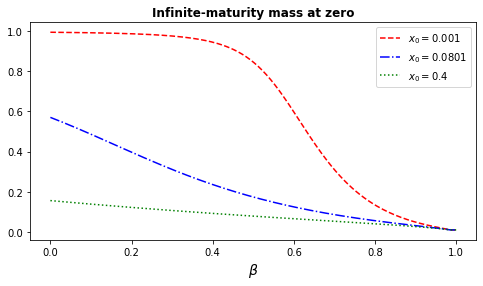

In [6]:
betas = np.linspace(betasMin, betasMax, nbbetas)
masses = [[SABR_mass_0_infty(y0, nu, beta, x0) for beta in betas] for x0 in xx0]

fig = plt.figure(figsize=(8,4))
plt.plot(betas, masses[0], 'r--', label='$x_0 = %s$' %xx0[0])
plt.plot(betas, masses[1], 'b-.', label = '$x_0 = %s$' %xx0[1])
plt.plot(betas, masses[2], 'g:', label='$x_0 = %s$' %xx0[2])
plt.title("Infinite-maturity mass at zero", fontsize=12, fontweight='bold')
plt.xlabel(r'$\beta$', fontsize=14)
plt.legend(loc=1)
plt.show()

### Influence of the starting point

In [7]:
nbx0 = 200
x0Min, x0Max = 1E-6, 0.24
betas = [0.2, 0.5, 0.7]

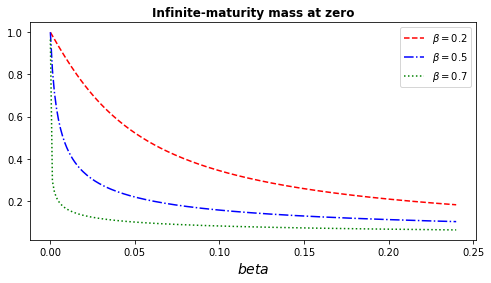

In [8]:
xx0 = np.linspace(x0Min, x0Max, nbx0)
masses = [[SABR_mass_0_infty(y0, nu, beta, x0) for x0 in xx0] for beta in betas] 
   
fig = plt.figure(figsize=(8,4))
plt.plot(xx0, masses[0], 'r--', label = r'$\beta = %s$' %betas[0])
plt.plot(xx0, masses[1], 'b-.', label=r'$\beta = %s$' %betas[1])
plt.plot(xx0, masses[2], 'g:', label = r'$\beta = %s$' %betas[2])
plt.title("Infinite-maturity mass at zero", fontsize=12, fontweight='bold')
plt.legend(loc = 1)
plt.xlabel(r'$beta$', fontsize=14)
plt.show()

# Asymptotic expansion and Error computations

The large-maturity mass at zero is given by

$$
\mathbb{P}(X_\infty=0) = 1 - 
\frac{y_0}{\nu\sqrt{2 \pi}}\int_{0}^{\infty}\Gamma\left(\frac{1}{2(1-\beta)},\frac{x_0^{2(1-\beta)}}{2r(1-\beta)^2}\right)
r^{-3/2}\exp\left(-\frac{y_0^2}{2 \nu^2 r}\right)\mathrm{d}r.
$$
For any $n\geq 0$, we define the $n$-th order approximation of the large-maturity mass at zero by
\begin{equation}
\mathbb{P}_\infty^{(N)} := \sum_{k=0}^n(-1)^k \left\{
\frac{2y_0(1-\beta)}{\Gamma\left(\frac{1}{2(1-\beta)}\right)\nu \sqrt{\pi}x_0^{1-\beta}}
\left(\frac{y_0^2(\beta-1)^2}{\nu^2x_0^{2(1-\beta)}}\right)^k
\frac{\Gamma\left(k+1+\frac{\beta}{2-2\beta}\right)}{k!(1+2k)}
\right\},
\end{equation}

In [9]:
def mass0_Sum(y0, nu, beta, x0, N):
    b1 = 1. - beta
    term1 = [gamma(k+1.+0.5*beta/b1) / ((1.+2.*k)*factorial(k)) for k in range(N+1)]
    term2 = [pow(y0*y0*b1*b1/(nu*nu*pow(x0, 2.*b1)), k) for k in range(N+1)]
    pp = np.sum([pow(-1., k)*te2*te for (k,te,te2) in zip(range(N+1), term1, term2)])
    return 2.*y0*b1/(gamma(0.5/b1)*nu*np.sqrt(np.pi)*pow(x0, b1))*pp   

### Numerical Tests
<a id="MCTests"></a>

In [10]:
y0, nu, beta, x0 = 0.1, 1., 0.2, 0.2

### Convergence of $\mathbb{P}^{N}_\infty$

In [63]:
m0 = SABR_mass_0_infty(y0, nu, beta, x0)
nn = np.arange(0, 11)
print("Mass at zero, infinite time: ", m0)

mm0 = [m0 for _ in nn]
pp0 = [mass0_Sum(y0, nu, beta, x0, n) for n in nn]
errors0 = [np.round(m0 - pp0[n], 3) for n in nn]
myCol = ['n=%.0f' %n for n in nn]

myTable = pd.DataFrame.from_dict({'n-th order':pp0, 'Error':errors0}, orient="index", columns=myCol)
myTable

Mass at zero, infinite time:  0.20839722471253042


,n=0,n=1,n=2,n=3,n=4,n=5,n=6,n=7,n=8,n=9,n=10
n-th order,0.214757,0.207988,0.208351,0.208328,0.20833,0.20833,0.20833,0.20833,0.20833,0.20833,0.20833
Error,-0.006000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


### Convergence of the truncated integral

We truncate the integral on the compact interval $[0, R]$

In [64]:
compTime, m0, errors = [], [], []
m0infty = mass0_Sum(y0, nu, beta, x0, 100)
RR = range(1, 60, 5)

mm0 = [SABR_mass_0_infty(y0, nu, beta, x0, R) for R in RR]
errors = ["{:.2E}".format(Decimal(m0 - m0infty)) for m0 in mm0]
mm0 = ["{:.4f}".format(Decimal(m0)) for m0 in mm0]

myCol = ['R=%.0f' %R for R in RR]
df = pd.DataFrame.from_dict({'Mass': mm0, 'Error':errors}, columns=myCol, orient="index")
df

,R=1,R=6,R=11,R=16,R=21,R=26,R=31,R=36,R=41,R=46,R=51,R=56
Mass,0.2150,0.2092,0.2088,0.2086,0.2086,0.2085,0.2085,0.2084,0.2084,0.2084,0.2084,0.2084
Error,6.68E-3,9.01E-4,4.56E-4,2.99E-4,2.20E-4,1.73E-4,1.42E-4,1.20E-4,1.04E-4,9.13E-5,8.13E-5,7.32E-5


# Monte Carlo computations

In [65]:
def mass_MC(nu, beta, x0, y0, T, delta, nbSimul):
    tRange = np.linspace(T+delta, delta)
    mass, dd = 0., np.sqrt(delta)
    paths = []
    for n in range(nbSimul):
        xx, yy = 0.*tRange, 0.*tRange
        xx[0], yy[0] = x0, y0
        g1, g2 = np.random.normal(0., 1., len(tRange)), np.random.normal(0., 1., len(tRange))
        
        for k in range(1, len(tRange)):
            if xx[k-1] > 0:
                tempy = yy[k-1]*np.exp(nu*dd*g1[k] - 0.5*nu*nu*delta)
                tempx = xx[k-1] + tempy*pow(xx[k-1], beta)*dd*g2[k]
                xx[k], yy[k] = tempx, tempy
            else:
                ## absorbing boundary condition
                xx[k-1], yy[k-1] = 0., 0.
                mass += 1.
                break
        paths.append(xx)
                
    mass = mass / (1.*nbSimul)
    return tRange, paths, mass

In [70]:
delta, nbSimul = 0.1, 1000
rho, y0, nu, beta, x0 = -0.7, 0.1, 1., 0.2, 0.2
T = 300.

In [71]:
tRange, paths, mass = mass_MC(nu, beta, x0, y0, T, delta, nbSimul)
print("Mass at zero by Monte Carlo: ", mass)
print("Mass at zero, analytical formula: ", SABR_mass_0_infty(y0, nu, beta, x0))

Mass at zero by Monte Carlo:  0.157
Mass at zero, analytical formula:  0.20839722471253042
